# Improve clinic access for ALS patients

Finding places where clinics for patients with ALS, could be established to improve patient access.

In [1]:
from arcgis import *
from IPython.display import display

In [2]:
gis = GIS(profile='als_demo')

<Item title:"ALS_Clinic_City_Candidates" type:Feature Layer Collection owner:david_johnson_NonProfit>
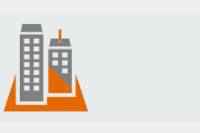

<Item title:"ALS_Clinic_90minDriveTime" type:Feature Layer Collection owner:david_johnson_NonProfit>
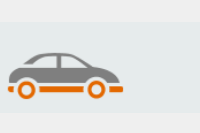

<Item title:"ALS_Clinics" type:Feature Layer Collection owner:david_johnson_NonProfit>
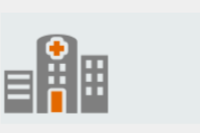

<Item title:"ALS_Patients" type:Feature Layer Collection owner:david_johnson_NonProfit>
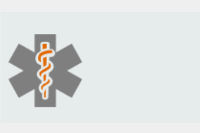

In [3]:
search_als = gis.content.search('tags: ALS_demo')
for item in search_als:
    display(item)

In [4]:
city_candidates = search_als[0]
drive_times = search_als[1]
als_clinics = search_als[2]
pals = search_als[3]

## Explore ALS data on a map

In [16]:
# Create a map of California.
map1 = gis.map("State of California, USA")
map1.height = '500px'
map1.basemap = 'dark-gray'
map1

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[0, 0])

In [17]:
map1.add_layer([drive_times, als_clinics, pals])

## Use GIS analysis to find the best location for a new ALS clinic

In [9]:
# Access the point data from the cities and patients items
cities = city_candidates.layers[0].query()
patients = pals.layers[0].query()

# Identify the city that will maximize coverage for ALS patients within a 90 minute drive time.
result = network.analysis.solve_location_allocation(
    problem_type                 = 'Maximize Coverage',
    travel_direction             = 'Demand to Facility',
    number_of_facilities_to_find = 1,
    facilities                   = cities,
    demand_points                = patients,
    default_measurement_cutoff   = 90,   
    measurement_units            = 'Minutes')

In [39]:
result.output_facilities.df[['Name', 'FacilityType', 'DemandCount', 'DemandWeight']]

,Name,FacilityType,DemandCount,DemandWeight
0,Bakersfield,0,0,0
1,Redding,0,0,0
2,Visalia,3,66,299
3,Santa Maria,0,0,0
4,Santa Barbara,0,0,0
5,Chico,0,0,0
6,Merced,0,0,0
7,Clovis,0,0,0
8,Fresno,0,0,0


In [40]:
# Create a map of Visalia, California
map2 = gis.map('Visalia, CA')
map2.layout.height = '500px'
map2.basemap = 'dark-gray'

# Display the map and add the analysis results to it
display(map2)

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[0, 0], layout=Layout(height='500px'))

### Map rendering code

In [12]:
from IPython.display import display
import time

def visualize_results(map_widget, solve_locate_allocate_result):
    m = map_widget
    result = solve_locate_allocate_result
    time.sleep(1.5)  
    
    # Extract the output data from the analysis results
    # Store the output points and lines in Panda's dataframes
    demand_df = result.output_demand_points.df
    lines_df = result.output_allocation_lines.df

    # Extract the allocated patients data.
    patients_allocated_df = demand_df[demand_df['DemandOID'].isin(lines_df['DemandOID'])]
    patients_allocated_fset = features.FeatureSet.from_dataframe(patients_allocated_df)

    # Extract the un-allocated patients data.
    patients_not_allocated_df = demand_df[~demand_df['DemandOID'].isin(lines_df['DemandOID'])]
    patients_not_allocated_fset = features.FeatureSet.from_dataframe(patients_not_allocated_df)

    # Extract the chosen clinic data.
    facilities_df = result.output_facilities.df[['Name', 'FacilityType', 'Weight','DemandCount', 'DemandWeight', 'SHAPE']]
    facility_chosen_df = facilities_df[facilities_df['FacilityType'] == 3]
    facility_chosen_fset = features.FeatureSet.from_dataframe(facility_chosen_df)

    # Define the map symbology
    # Allocation lines
    allocation_line_symbol_1 = {
        'type': 'esriSLS',
        'style': 'esriSLSSolid',
        'color': [255,255,255,153],
        'width': 0.7
    }
    allocation_line_symbol_2 = {
        'type': 'esriSLS',
        'style': 'esriSLSSolid',
        'color': [0,255,197,39],
        'width': 3
    }
    allocation_line_symbol_3 = {
        'type': 'esriSLS',
        'style': 'esriSLSSolid',
        'color': [0,92,230,39],
        'width': 7
    }
    
    # Patient points within 90 minutes drive time to a proposed clinic location.
    allocated_patient_symbol = {
        'type' : 'esriPMS',
        'url' : 'https://maps.esri.com/legends/Firefly/cool/1.png',
        'contentType' : 'image/png',
        'width' : 26,
        'height' : 26,
        'angle' : 0,
        'xoffset' : 0,
        'yoffset' : 0
    }

    # Patient points outside of a 90 minutes drive time to a proposed clinic location.
    unallocated_patient_symbol = {
        'type' : 'esriPMS',
        'url' : 'https://maps.esri.com/legends/Firefly/warm/1.png',
        'contentType' : 'image/png',
        'width' : 19.5,
        'height' : 19.5,
        'angle' : 0,
        'xoffset' : 0,
        'yoffset' : 0
    }

    # Selected clinic
    clinic_site_symbol = {
        'type' : 'esriPMS',
        'url' : 'https://maps.esri.com/legends/Firefly/ClinicSites.png',
        'contentType' : 'image/png',
        'width' : 26,
        'height' : 26,
        'angle' : 0,
        'xoffset' : 0,
        'yoffset' : 0
    }
    
    # Display the patient-clinic allocation lines.
    m.draw(shape=result.output_allocation_lines, symbol=allocation_line_symbol_3)
    m.draw(shape=result.output_allocation_lines, symbol=allocation_line_symbol_2)
    m.draw(shape=result.output_allocation_lines, symbol=allocation_line_symbol_1)
 

    # Display the locations of patients within the specified drive time to the selected clinic.
    m.draw(shape=patients_allocated_fset, symbol=allocated_patient_symbol)

    # Display the locations of patients outside the specified drive time to the selected clinic.
    m.draw(shape=patients_not_allocated_fset, symbol=unallocated_patient_symbol)

    # Display the chosen clinic site.
    m.draw(shape=facility_chosen_fset, symbol=clinic_site_symbol)

    # Zoom out to display all of the allocated patients points.
    time.sleep(0.5) 
    m.zoom = 8

### View results

In [41]:
visualize_results(map2, result)

### Save results as a web map

In [11]:
map2.save({'title':'ALS Analysis', 'tags':'ALS, clinics', 'snippet':'New clinic location for ALS clinic'})

<Item title:"ALS Analysis" type:Web Map owner:david_johnson_NonProfit>